In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

#python imports
import time, math, random, datetime

#Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
# Import train & test Data
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
# example of submission file

In [3]:
# view training data
train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [4]:
len(train) #Training set size

891

In [5]:
test.head() #View test Data

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [6]:
len(test) # test set size

418

In [7]:
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [8]:
# Data description
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

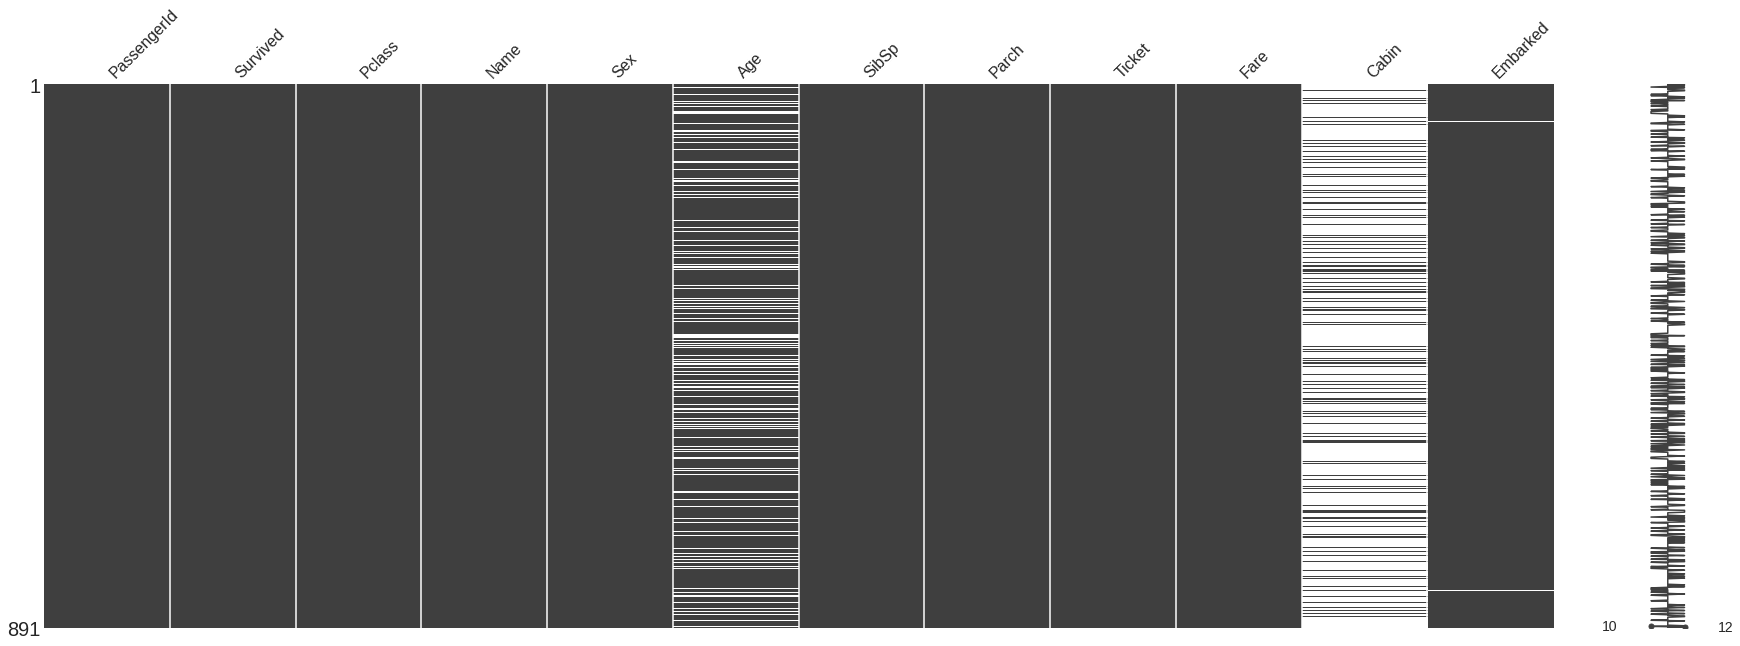

In [9]:
# Missing values visualization(Data)
missingno.matrix(train, figsize = (30,10))

In [10]:
# Let's see how many missing values there are on each feature/column on the data
def find_missing_values(df, columns):
    missing_values = {}
    length = len(df)
    for feature in columns:
        total = df[feature].value_counts().sum()
        missing_values[feature] = length - total
        
    return missing_values

mv = find_missing_values(train, columns = train.columns)
mv  

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [11]:
# Another way to see the missing values of each column is this:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# We create two dataFrames for separate the discrete variables from the continuous variables
df_con = pd.DataFrame() # For continuous variables
df_dis = pd.DataFrame() # For discrete variables

In [13]:
# We check each dataType of the columns for explore them individually
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [14]:
# Let's explore each feature individually, but first let's take another look at the data
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

0    549
1    342
Name: Survived, dtype: int64


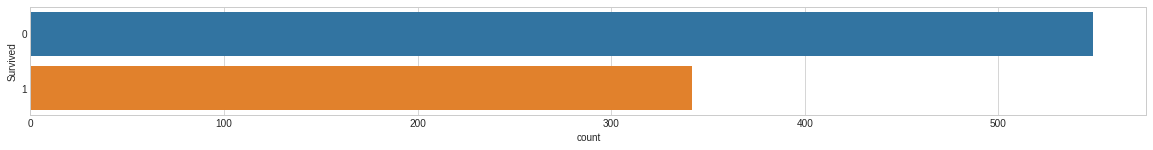

In [15]:
# We're gonna plot the feature 'Survived':
# And see how many people survived
fig = plt.figure(figsize = (20, 2))
sns.countplot(y = 'Survived', data = train)
print(train.Survived.value_counts())

In [16]:
# We add this feature to our subsets
df_con['Survived'] = train['Survived']
df_dis['Survived'] = train['Survived']

In [17]:
df_con.head()

Survived
0         0
1         1
2         1
3         1
4         0

In [18]:
df_dis.head()

Survived
0         0
1         1
2         1
3         1
4         0

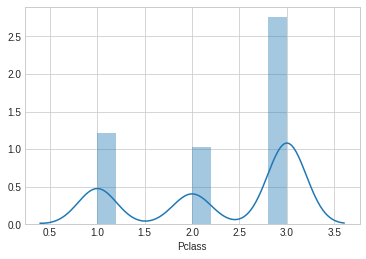

In [19]:
# Now we'll look at the feature 'Pclass' by looking at the distribution for check outliers
sns.distplot(train['Pclass'])

In [20]:
mv['Pclass']
# train.Pclass.isnull().sum()

0

In [21]:
# add the feature to our subsets data
df_con['Pclass'] = train['Pclass']
df_dis['Pclass'] = train['Pclass']
df_con.head()

Survived  Pclass
0         0       3
1         1       1
2         1       3
3         1       1
4         0       3

In [22]:
# The feature Name, we'll analize it with the function value_counts
train.Name.value_counts()

Ridsdale, Miss. Lucy                             1
West, Mrs. Edwy Arthur (Ada Mary Worth)          1
Weisz, Mrs. Leopold (Mathilde Francoise Pede)    1
Rogers, Mr. William John                         1
Pavlovic, Mr. Stefo                              1
                                                ..
Haas, Miss. Aloisia                              1
Jensen, Mr. Niels Peder                          1
Nicola-Yarred, Master. Elias                     1
Hagland, Mr. Konrad Mathias Reiersen             1
Romaine, Mr. Charles Hallace ("Mr C Rolmane")    1
Name: Name, Length: 891, dtype: int64

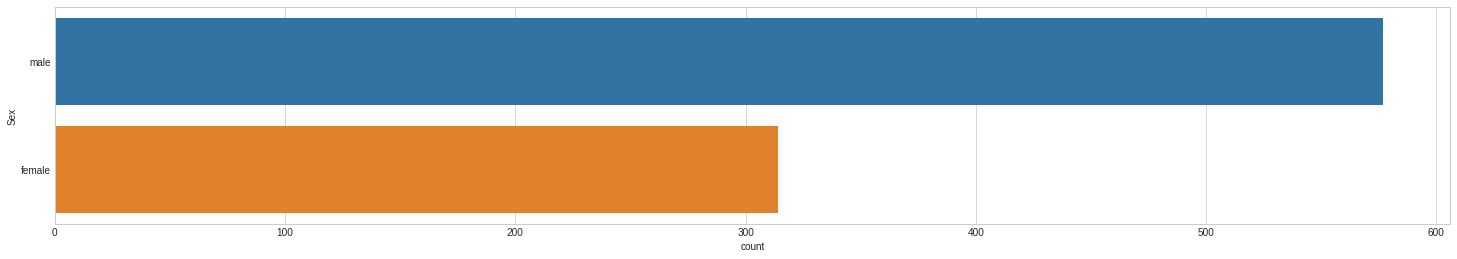

In [23]:
# Now lets pass to the feature sex.
# lets view the distribution of sex.
plt.figure(figsize = (25, 4))
sns.countplot(y = 'Sex', data = train)

In [24]:
# missing values on the column
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [25]:
# lets add it to our subsets, but in the discret variable subset instead of male,female, we'll add it as 0, 1.
df_dis['Sex'] = train['Sex']
df_dis['Sex'] = np.where(df_dis['Sex'] == 'female', 1, 0)# 0 for male, 1 for female
df_con['Sex'] = train['Sex']

In [26]:
df_dis.head()

Survived  Pclass  Sex
0         0       3    0
1         1       1    1
2         1       3    1
3         1       1    1
4         0       3    0

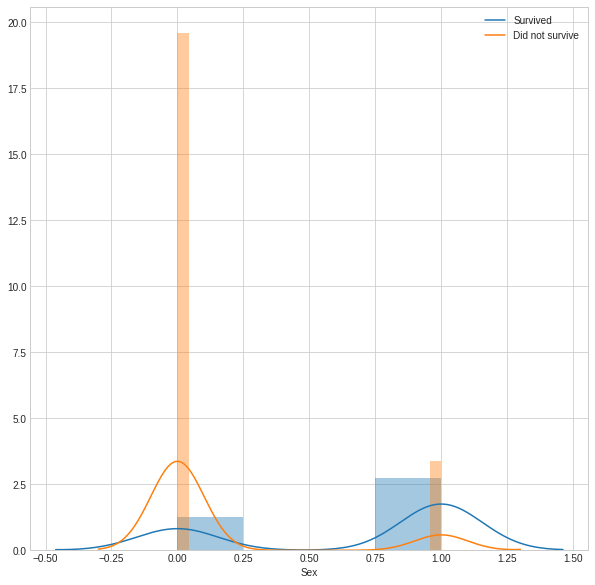

In [27]:
# Now, how does the Sex variable look compared to Survival?
# they're both binarys, we can see his
fig = plt.figure(figsize = (10, 10))
sns.distplot(df_dis.loc[df_dis['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'})
sns.distplot(df_dis.loc[df_dis['Survived'] == 0]['Sex'], kde_kws={'bw': 0.1, 'label': 'Did not survive'})

In [28]:
# How many missing values are in the feature Age?
train.Age.isnull().sum()

177

In [29]:
# For the moment we won't add this feature in our subsets, but we can also fill the missing values with Linear Regression

In [30]:
# Function that creates two diferent types of graphs
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw': 0.1});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw': 0.1});

In [31]:
# We will start with the feature SibSp by counting the missing values
train.SibSp.isnull().sum()

0

In [32]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [33]:
# Lets add it to our subsets
df_con['SibSp'] = train['SibSp']
df_dis['SibSp'] = train['SibSp']

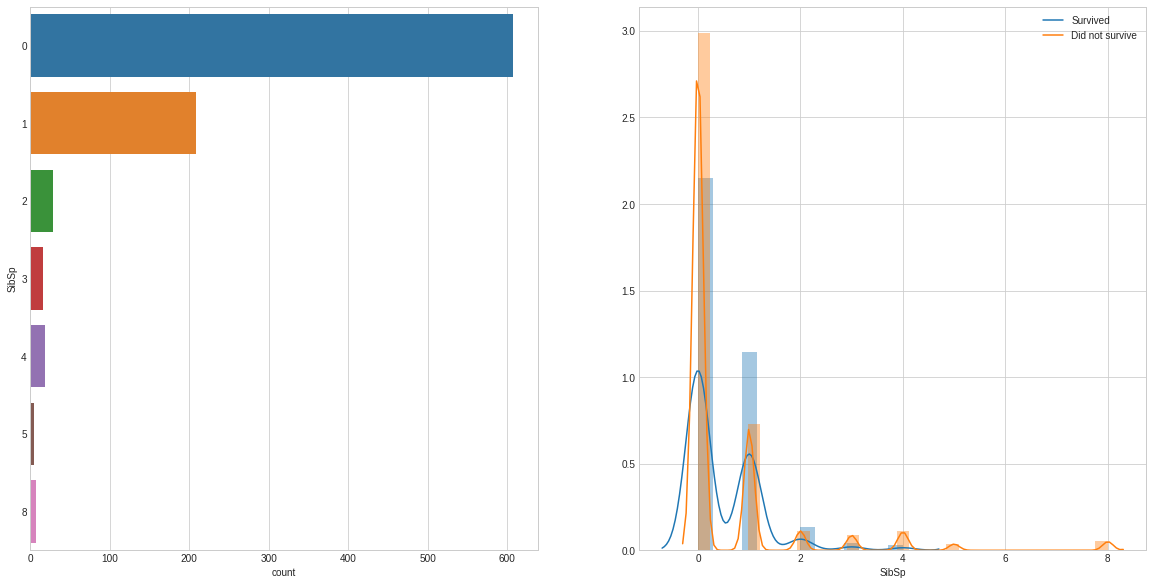

In [34]:
#We'll graph our info about the number of persons that had siblings on titanic
# the second graph is the info of the first compared to the survival ratio
plot_count_dist(train, bin_df = df_dis,
               label_column = 'Survived',
               target_column = 'SibSp',
               figsize = (20, 10))

In [35]:
# The Parch feature is very similar to SibSp, so the process to analize it is the same
train.Parch.isnull().sum()

0

In [36]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [37]:
df_con['Parch'] = train['Parch']
df_dis['Parch'] = train['Parch']

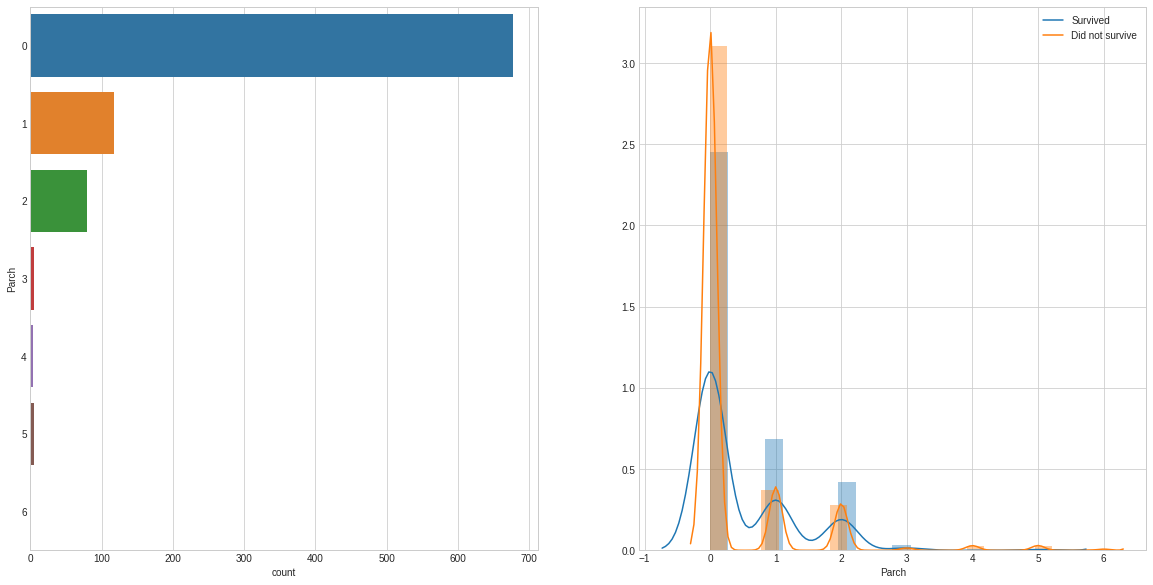

In [38]:
plot_count_dist(train, bin_df = df_dis,
               label_column = 'Survived',
               target_column = 'Parch',
               figsize = (20, 10))

In [39]:
# lets visualize one of our dataframes and check if everything is all right by checking also the original training data
df_con.head()

Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0

In [40]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [41]:
# Ticket feature
train.Ticket.isnull().sum()

0

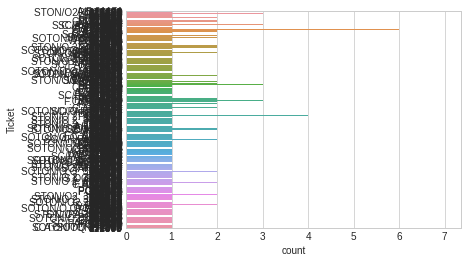

In [42]:
# How many kinds of ticket are there?
sns.countplot(y = "Ticket", data = train)

In [43]:
# Another way to visualize that is:
train.Ticket.value_counts()

CA. 2343    7
347082      7
1601        7
CA 2144     6
3101295     6
           ..
350035      1
19947       1
350406      1
370372      1
36866       1
Name: Ticket, Length: 681, dtype: int64

In [44]:
# there are 681 unique ticket values.
# there may be some way to reduce this down. But We're gonna eliminate it

In [45]:
# For the feature Fare is a similar process
train.Fare.isnull().sum()

0

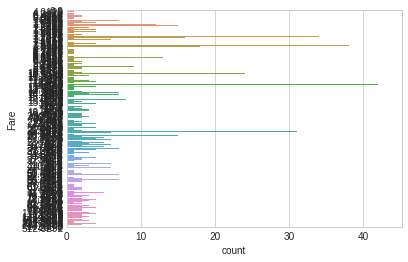

In [46]:
sns.countplot(y = "Fare", data = train)

In [47]:
train.Fare.dtypes

dtype('float64')

In [48]:
# Because Fare its a continuous value we're gonna add it to our continuous variables dataframe
# and in the categorical variables dataframe we're gonna add it as a discrete value by cut it in 5.
df_con['Fare'] = train['Fare']
df_dis['Fare'] = pd.cut(train['Fare'], bins = 5)

In [49]:
df_dis.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

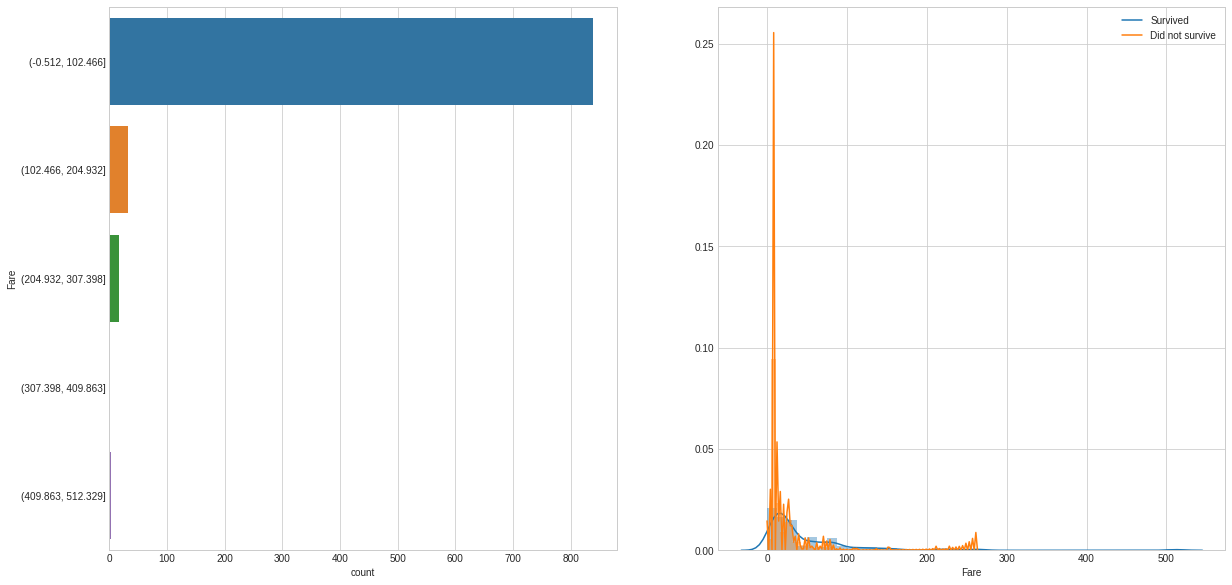

In [50]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data = train,
                bin_df = df_dis,
                label_column = 'Survived', 
                target_column = 'Fare', 
                figsize = (20,10), 
                use_bin_df = True)

In [51]:
# Feature cabin
train.Cabin.isnull().sum()

687

In [52]:
# Wow, there's a lot of missing values, lets see how do the cabin values looks like
train.Cabin.value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
F33            3
              ..
A14            1
B69            1
C32            1
D28            1
D48            1
Name: Cabin, Length: 147, dtype: int64

In [53]:
# We wont be using Cabin, cause of the lots of missing values

In [54]:
# Feature: Embarked
train.Embarked.isnull().sum()

2

In [55]:
# As we see, there are two missing values
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

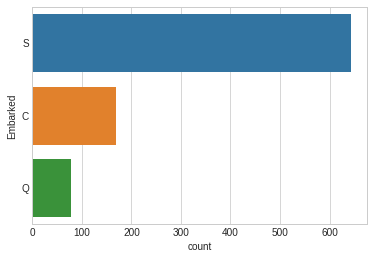

In [56]:
# Visualize the distribution
sns.countplot(y = "Embarked", data = train)

In [57]:
# We're gonna drop the missing values:
df_dis['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [58]:
print("Length of the subDataFrame before removing the rows: ", len(df_con))
df_con = df_con.dropna(subset = ['Embarked'])
df_dis = df_dis.dropna(subset = ['Embarked'])
print("Length of the subDataFrame after removing the rows: ", len(df_con))

Length of the subDataFrame before removing the rows:  891
Length of the subDataFrame after removing the rows:  889


In [59]:
# Now lets see our two sub dataframes
df_con.head()

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S

In [60]:
df_dis.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 102.466]        S
1         1       1    1      1      0  (-0.512, 102.466]        C
2         1       3    1      0      0  (-0.512, 102.466]        S
3         1       1    1      1      0  (-0.512, 102.466]        S
4         0       3    0      0      0  (-0.512, 102.466]        S

In [61]:
# Now, before to apply machine learning models lets do feature encoding and transorm the data to a more understandable data for a ML model

In [62]:
# One hot encode binary variables
one_hot_columns = df_dis.columns.tolist()
one_hot_columns.remove('Survived')
df_dis_enc = pd.get_dummies(df_dis, columns = one_hot_columns)
df_dis_enc.head()

Survived  Pclass_1  Pclass_2  Pclass_3  Sex_0  Sex_1  SibSp_0  SibSp_1  \
0         0         0         0         1      1      0        0        1   
1         1         1         0         0      0      1        0        1   
2         1         0         0         1      0      1        1        0   
3         1         1         0         0      0      1        0        1   
4         0         0         0         1      1      0        1        0   

   SibSp_2  SibSp_3  ...  Parch_5  Parch_6  Fare_(-0.512, 102.466]  \
0        0        0  ...        0        0                       1   
1        0        0  ...        0        0                       1   
2        0        0  ...        0        0                       1   
3        0        0  ...        0        0                       1   
4        0        0  ...        0        0                       1   

   Fare_(102.466, 204.932]  Fare_(204.932, 307.398]  Fare_(307.398, 409.863]  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   Fare_(409.863, 512.329]  Embarked_C  Embarked_Q  Embarked_S  
0                        0           0           0           1  
1                        0           1           0           0  
2                        0           0           0           1  
3                        0           0           0           1  
4                        0           0           0           1  

[5 rows x 28 columns]

In [63]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S

In [64]:
#One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], prefix = 'embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], prefix = 'sex')

df_pclass_one_hot = pd.get_dummies(df_con['Pclass'], prefix = 'pclass')

In [65]:
#combine the columns
df_con_enc = pd.concat([df_con, df_embarked_one_hot, df_sex_one_hot, df_pclass_one_hot], axis = 1)

#Drop the original columns cause they have been encoded already
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis = 1)

In [66]:
df_con_enc.head()

Survived  SibSp  Parch     Fare  embarked_C  embarked_Q  embarked_S  \
0         0      1      0   7.2500           0           0           1   
1         1      1      0  71.2833           1           0           0   
2         1      0      0   7.9250           0           0           1   
3         1      1      0  53.1000           0           0           1   
4         0      0      0   8.0500           0           0           1   

   sex_female  sex_male  pclass_1  pclass_2  pclass_3  
0           0         1         0         0         1  
1           1         0         1         0         0  
2           1         0         0         0         1  
3           1         0         1         0         0  
4           0         1         0         0         1

In [67]:
#Lets start building machine learning models and separating the data
#The data we will use to train the models is our continous data:
selected_df = df_con_enc

In [68]:
#Split the dataframes into data and labels
X_train = selected_df.drop('Survived', axis = 1)
y_train = selected_df['Survived']

In [69]:
X_train.shape

(889, 11)

In [70]:
X_train.head()

SibSp  Parch     Fare  embarked_C  embarked_Q  embarked_S  sex_female  \
0      1      0   7.2500           0           0           1           0   
1      1      0  71.2833           1           0           0           1   
2      0      0   7.9250           0           0           1           1   
3      1      0  53.1000           0           0           1           1   
4      0      0   8.0500           0           0           1           0   

   sex_male  pclass_1  pclass_2  pclass_3  
0         1         0         0         1  
1         0         1         0         0  
2         0         0         0         1  
3         0         1         0         0  
4         1         0         0         1

In [71]:
y_train.shape

(889,)

In [72]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [73]:
#First lets create a function that runs all machine learning models
def fit_ml_algo(algo, X_train, y_train, cv):
    #Fit
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # K-fold Cross Validation
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train,
                                                  cv = cv, n_jobs = -1)
    
    #Cross Validation accuracy
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [74]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                 X_train, y_train, 10)

log_time = (time.time() - start_time)
print("Train Accuracy: ", acc_log)
print("10 - fold Cross validation: ", acc_cv_log)
print("Runing time: ", datetime.timedelta(seconds = log_time))

Train Accuracy:  79.98
10 - fold Cross validation:  79.42
Runing time:  0:00:01.660906


In [75]:
#K-Nearest Neighbors
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                 X_train, y_train, 10)

knn_time = (time.time() - start_time)
print("Train Accuracy: ", acc_knn)
print("10 - fold Cross validation: ", acc_cv_knn)
print("Runing time: ", datetime.timedelta(seconds = knn_time))

Train Accuracy:  83.46
10 - fold Cross validation:  76.72
Runing time:  0:00:00.181840


In [76]:
#Gaussian Naive Bayes
start_time = time.time()
train_pred_gnv, acc_gnv, acc_cv_gnv = fit_ml_algo(GaussianNB(),
                                                 X_train, y_train, 10)

gnv_time = (time.time() - start_time)
print("Train Accuracy: ", acc_gnv)
print("10 - fold Cross validation: ", acc_cv_gnv)
print("Runing time: ", datetime.timedelta(seconds = gnv_time))

Train Accuracy:  78.52
10 - fold Cross validation:  77.95
Runing time:  0:00:00.145931


In [77]:
# Linear Support Vector Machines
start_time = time.time()
train_pred_svm, acc_svm, acc_cv_svm = fit_ml_algo(LinearSVC(),
                                                 X_train, y_train, 10)

svm_time = (time.time() - start_time)
print("Train Accuracy: ", acc_svm)
print("10 - fold Cross validation: ", acc_cv_svm)
print("Runing time: ", datetime.timedelta(seconds = svm_time))

Train Accuracy:  78.29
10 - fold Cross validation:  76.04
Runing time:  0:00:00.532113


In [78]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                 X_train, y_train, 10)

sgd_time = (time.time() - start_time)
print("Train Accuracy: ", acc_sgd)
print("10 - fold Cross validation: ", acc_cv_sgd)
print("Runing time: ", datetime.timedelta(seconds = sgd_time))

Train Accuracy:  72.67
10 - fold Cross validation:  68.5
Runing time:  0:00:00.147218


In [79]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dtc, acc_dtc, acc_cv_dtc = fit_ml_algo(DecisionTreeClassifier(),
                                                 X_train, y_train, 10)

dtc_time = (time.time() - start_time)
print("Train Accuracy: ", acc_dtc)
print("10 - fold Cross validation: ", acc_cv_dtc)
print("Runing time: ", datetime.timedelta(seconds = dtc_time))

Train Accuracy:  92.46
10 - fold Cross validation:  80.54
Runing time:  0:00:00.154311


In [80]:
#Gradient Boost Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                 X_train, y_train, 10)

gbt_time = (time.time() - start_time)
print("Train Accuracy: ", acc_gbt)
print("10 - fold Cross validation: ", acc_cv_gbt)
print("Runing time: ", datetime.timedelta(seconds = gbt_time))

Train Accuracy:  86.61
10 - fold Cross validation:  80.65
Runing time:  0:00:01.149972


In [81]:
# CatBoost Algorithm
"""
This is an State-of-the-art algorithm that mixes a lot about secision trees,
gradient boosting trees, etc.
"""

'\nThis is an State-of-the-art algorithm that mixes a lot about secision trees,\ngradient boosting trees, etc.\n'

In [82]:
#lets look at our training data
X_train.head()

SibSp  Parch     Fare  embarked_C  embarked_Q  embarked_S  sex_female  \
0      1      0   7.2500           0           0           1           0   
1      1      0  71.2833           1           0           0           1   
2      0      0   7.9250           0           0           1           1   
3      1      0  53.1000           0           0           1           1   
4      0      0   8.0500           0           0           1           0   

   sex_male  pclass_1  pclass_2  pclass_3  
0         1         0         0         1  
1         0         1         0         0  
2         0         0         0         1  
3         0         1         0         0  
4         1         0         0         1

In [83]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [84]:
# Lets define the categorical features for the catboost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [85]:
# CatBoost has picked up that all variables except Fare can be treated as categorical.
# Lets use the pool function for pool together all the data
train_pool = Pool(X_train, y_train,
                 cat_features)

In [86]:
# catboost model:
catboost_model = CatBoostClassifier(iterations = 1000,
                                   custom_loss = ['Accuracy'],
                                   loss_function = 'Logloss')

# Fit catboost model
catboost_model.fit(train_pool, plot = True)

#Catboost Accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.009797


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6862830	total: 60.5ms	remaining: 1m
1:	learn: 0.6809444	total: 62.9ms	remaining: 31.4s
2:	learn: 0.6751692	total: 65.9ms	remaining: 21.9s
3:	learn: 0.6689060	total: 68.6ms	remaining: 17.1s
4:	learn: 0.6632144	total: 71.3ms	remaining: 14.2s
5:	learn: 0.6576488	total: 73.3ms	remaining: 12.2s
6:	learn: 0.6544441	total: 74.3ms	remaining: 10.5s
7:	learn: 0.6490635	total: 76.7ms	remaining: 9.52s
8:	learn: 0.6443241	total: 79.5ms	remaining: 8.75s
9:	learn: 0.6395935	total: 82ms	remaining: 8.12s
10:	learn: 0.6345186	total: 84.2ms	remaining: 7.57s
11:	learn: 0.6305316	total: 86.6ms	remaining: 7.13s
12:	learn: 0.6275610	total: 87.8ms	remaining: 6.67s
13:	learn: 0.6225020	total: 90.3ms	remaining: 6.36s
14:	learn: 0.6179503	total: 92.8ms	remaining: 6.1s
15:	learn: 0.6140480	total: 94.1ms	remaining: 5.78s
16:	learn: 0.6100034	total: 96ms	remaining: 5.55s
17:	learn: 0.6049646	total: 98.7ms	remaining: 5.38s
18:	learn: 0.6025760	total: 99.7ms	remaining: 5.15s
19:	learn: 0.5998630	total: 10

In [87]:
# time
start_time = time.time()

# set params for cross validation
cv_params = catboost_model.get_params()

# run the cross validation with 10 folds
cv_data = cv(train_pool, cv_params,
            fold_count = 10, plot = True)

#Time
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)	total: 293ms	remaining: 4m 52s
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 582ms	remaining: 4m 50s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)	total: 876ms	remaining: 4m 51s
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)	total: 1.16s	remaining: 4m 49s
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)	total: 1.43s	remaining: 4m 43s
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)	total: 1.68s	remaining: 4m 39s
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)	total: 1.94s	remaining: 4m 35s
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)	total: 2.19s	remaining: 4m 31s
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)	total: 2.44s	remaining: 4m 28s
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)	total: 2.69s	remaining: 4m 26s
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)	total: 2.94s	remaining: 4m 24s
11:	learn: 0.5447302	test: 0.5517930	best

In [88]:
#Accuracy of catboost
print("--CatBoost Metrics--")
print("Accuracy: ", acc_catboost)
print("10-fold Cross Validation: ", acc_cv_catboost)
print("Runing time: ", datetime.timedelta(seconds = catboost_time))

--CatBoost Metrics--
Accuracy:  83.91
10-fold Cross Validation:  81.32
Runing time:  0:05:15.496821


In [89]:
#Model results
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gnv, 
        acc_sgd, 
        acc_svm, 
        acc_dtc,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model  Score
5               Decision Tree  92.46
6     Gradient Boosting Trees  86.61
7                    CatBoost  83.91
0                         KNN  83.46
1         Logistic Regression  79.98
2                 Naive Bayes  78.52
4                  Linear SVC  78.29
3  Stochastic Gradient Decent  72.67

In [90]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gnv, 
        acc_cv_sgd, 
        acc_cv_svm, 
        acc_cv_dtc,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
7                    CatBoost  81.32
6     Gradient Boosting Trees  80.65
5               Decision Tree  80.54
1         Logistic Regression  79.42
2                 Naive Bayes  77.95
0                         KNN  76.72
4                  Linear SVC  76.04
3  Stochastic Gradient Decent  68.50

In [91]:
# Because CatBoost got the best accuracy we will use it to predict on the test set


# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

imp         col
4    0.992061  embarked_Q
3    1.213711  embarked_C
5    1.677219  embarked_S
9    2.178083    pclass_2
8    3.243021    pclass_1
0   10.797435       SibSp
10  11.205450    pclass_3
1   13.988886       Parch
2   15.753218        Fare
6   17.695520  sex_female
7   21.255397    sex_male

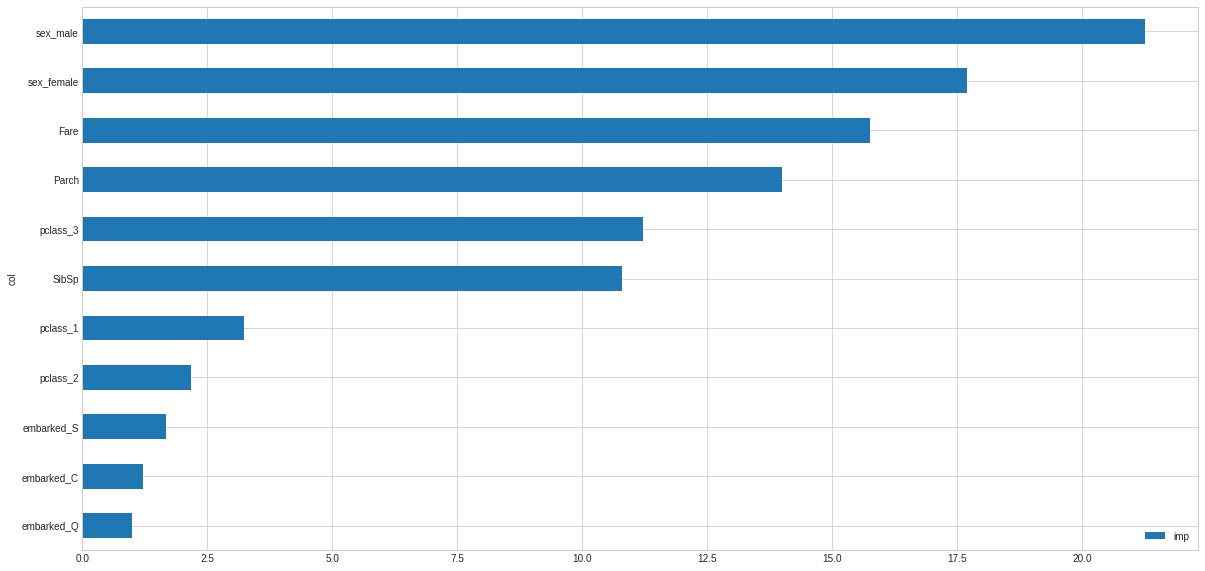

In [92]:
feature_importance(catboost_model, X_train) #Relevance of each feature

In [93]:
# Another metrics for evaluate our model
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


In [94]:
# now, for the submission we have to apply the same one hot encoding that we applied to the train test
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [95]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_pclass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [96]:
test = pd.concat([test,
                test_embarked_one_hot,
                test_sex_one_hot,
                test_pclass_one_hot],
                axis = 1)
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  embarked_C  \
0  34.5      0      0   330911   7.8292   NaN        Q           0   
1  47.0      1      0   363272   7.0000   NaN        S           0   
2  62.0      0      0   240276   9.6875   NaN        Q           0   
3  27.0      0      0   315154   8.6625   NaN        S           0   
4  22.0      1      1  3101298  12.2875   NaN        S           0   

   embarked_Q  embarked_S  sex_female  sex_male  pclass_1  pclass_2  pclass_3  
0           1           0           0         1         0         0         1  
1           0           1           1         0         0         0         1  
2           1           0           0         1         0         1         0  
3           0           1           0         1         0         0         1  
4           0           1           1         0         0         0         1

In [97]:
# create a list of columns that will be used in the predictions
wanted_test_cols = X_train.columns
wanted_test_cols

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [98]:
# We create our predictions vector
predictions = catboost_model.predict(test[wanted_test_cols])
predictions[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [99]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [100]:
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [101]:
# check if the dataframe is the same length as the example
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [102]:
submission.to_csv('my_submission.csv', index = False)
print('Submission CSV is ready!')

Submission CSV is ready!
